# 1. Imports

In [1]:
import json
import math
import scipy
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics 
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
from numpy.random import randn
from random import *
from statistics import mode
from scipy import stats
%matplotlib inline

# 2. Preparations
## 2.1 Load Data

In [2]:
classrooms = json.load(open('data/raw_data/classrooms.json', 'r'))
pupils = json.load(open('data/raw_data/pupils.json', 'r'))

df = pd.read_pickle('data/processed/df.pkl')
surveysliders = pd.read_pickle('data/processed/surveySlider.pkl')
inputfields = pd.read_pickle('data/processed/inputFields.pkl')
multipleChoice = pd.read_pickle('data/processed/multipleChoice.pkl')
freetext = pd.read_pickle('data/processed/freetext.pkl')
task_df = pd.read_pickle('data/processed/task_df.pkl')
pupil_performance_df = pd.read_pickle('data/processed/pupil_performance.pkl')
# Laden der Datei, in der händisch alle Freitext-Antworten bewertet wurden
pupil_performance_df_rated = pd.read_csv('data/processed/pupil_performance_3.csv', delimiter=';')
pupil_performance_df_rated = pupil_performance_df_rated.set_index('pupilId')

df['duration'] = pd.to_numeric(df['duration'])
surveysliders['duration'] = pd.to_numeric(surveysliders['duration'])
inputfields['duration'] = pd.to_numeric(inputfields['duration'])
multipleChoice['duration'] = pd.to_numeric(multipleChoice['duration'])
freetext['duration'] = pd.to_numeric(freetext['duration'])

In [3]:
#map the classIds to class numbers
classIdListe = ['qFEyvypMn4sAwLwtc', 'GkQSJvPTRWsLnpyR9', 'hZ9Hi9DLZSm5JMbNm', 'NCm8NNbAmNsur5S33', '2xefmoTfmYkhhAZYp', 'Rv7Wf522ZgQhs5LdX', 'Fj6vLBZ78KswTxcPt', 'SwfuMxSGoy4aKziD8', '93uw8K4BBFGYSbYRK', '3dLAJPXXug3EMqbc5', 'brSDebuCak3FfQsg6']
classNumberList = [str(num+1) for num in range(len(classIdListe))]
classNameDict = {key:value for key, value in zip(classIdListe, classNumberList)}

classIds = []

for index, row in pupil_performance_df_rated.iterrows():
    classIds.append(classNameDict[row["classId"]])

pupil_performance_df_rated["classId"] = classIds
pupil_performance_df_rated["classId"] = pd.to_numeric(pupil_performance_df_rated["classId"])

In [4]:
pupil_performance_df_rated.head()

,nr_tasks_per_pupil,total_duration in minutes,average duration per task in minutes,AI-1-v2-1-1,AI-4-v2-1-4,EvalML-1-1,ML-2-1-1,EvalML-1-5,AI-4-v2-1-5,EvalML-1-2,...,AIClosing-1-8_eval,AIClosing-1-8_null_answer,AIClosing-1-8_unknown,AIClosing-1-8_correct_points,AIClosing-1-8_incorrect_points,AIClosing-1-8_irrelevant_points,AIClosing-1-8_rating_content,AIClosing-1-8_rating_format,AIClosing-1-8_rating_creativity,classId
pupilId,,,,,,,,,,,,,,,,,,,,,
Ay6mfswm3SFcQdNJg,66,120.116667,1.819949,62.0,91.0,81.0,71.0,75.0,90.0,90.0,...,pending,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
Z9DkQMmtiPiHtteME,4,25.950000,6.487500,43.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
sqBXKssFvS8pFYAMv,66,66.650000,1.009848,89.0,99.0,96.0,79.0,93.0,100.0,98.0,...,correct,NaN,NaN,NaN,NaN,NaN,5.0,5.0,5.0,1
Kd6FuRsrq6QvPrkKp,6,37.383333,6.230556,78.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
jRT6yzZ2ip5ab5ZFM,66,66.566667,1.008586,90.0,88.0,76.0,71.0,69.0,72.0,100.0,...,correct,NaN,NaN,NaN,NaN,NaN,5.0,5.0,5.0,1


## 2.2 Prepare Helper functions

In [5]:
def calculateDifferences(df):
    """Takes a dataframe and returns the differences between the first two columns as a list"""
    differences= []
    for pupilId in df.dropna().index:
        differences.append(df.loc[pupilId, df.columns[0]]-df.loc[pupilId, df.columns[1]])
    return differences

def spearmanr_pval(x,y):
    """returns the p-value of the correlations calculated with spearmans rho"""
    return stats.spearmanr(x,y)[1]
    
def cohen_d(x,y):
    """Returns cohens d for two populations"""
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)
    

# 3. Itemschwierigkeit Antwortoptionen

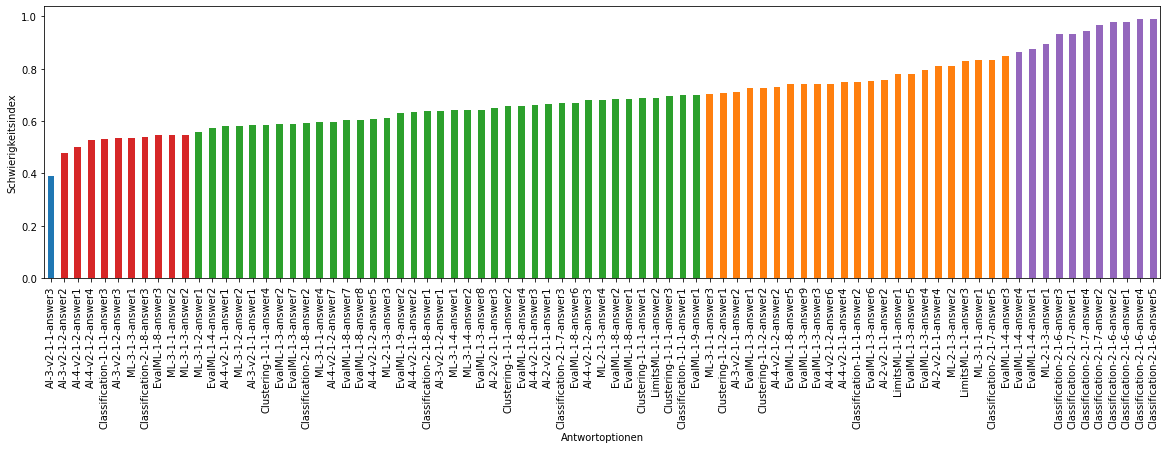

In [147]:
MA_mcs_taskIds = ["AI-2-v2-1-1", "AI-3-v2-1-1", "AI-3-v2-1-2", "AI-4-v2-1-1", "AI-4-v2-1-2", "ML-2-1-3", "ML-3-1-1", "ML-3-1-2", "ML-3-1-3", "ML-3-1-4", "Clustering-1-1-1", "Clustering-1-1-2", "Classification-1-1-1", "Classification-2-1-6", "Classification-2-1-7", "Classification-2-1-8", "LimitsML-1-1", "EvalML-1-3", "EvalML-1-4", "EvalML-1-8", "EvalML-1-9"]

answersByDifficulty = {"Antwortoptionen": [], "Schwierigkeitsindex der Antwortoption": []}

for taskId in MA_mcs_taskIds:
    task_i = multipleChoice[multipleChoice["taskId"] == taskId]
    sampleSolution_i = list(task_i["sampleSolution"][0:1])[0]
    
    with_false_attempts = task_i[task_i["falseAttempts"] == task_i["falseAttempts"]]
    first_falseAttempts_i = [elem[0] for elem in with_false_attempts["falseAttempts"]]
    nr_errors_in_first_false_attempt = np.array([0 for answer in sampleSolution_i])
    for falseAttempt in first_falseAttempts_i:
        nr_errors_in_first_false_attempt += np.array([a != f for a,f in zip(sampleSolution_i,falseAttempt)]).astype(int)
    
    for index, entry in pd.DataFrame(nr_errors_in_first_false_attempt).iterrows():
        answersByDifficulty["Antwortoptionen"].append(taskId+"-answer"+str(index+1))
        answersByDifficulty["Schwierigkeitsindex der Antwortoption"].append(round((len(task_i)-entry[0])/len(task_i),3))

answersByDifficultyDf = pd.DataFrame(answersByDifficulty).set_index('Antwortoptionen')
answersByDifficultyDf.sort_values(by=['Schwierigkeitsindex der Antwortoption'], inplace=True, ascending=True)

# to plot the bras in different colors
numbers = [1, 10, 38, 23, 11]
colors = []
#colourmap = ["red", "mediumvioletred", "purple", "blueviolet",  "blue"]
colourmap = ["tab:blue", 'tab:red', 'tab:green', 'tab:orange', 'tab:purple']
for index, number in enumerate(numbers):
    for i in range(number):
        colors.append(colourmap[index])

series = pd.Series(answersByDifficultyDf["Schwierigkeitsindex der Antwortoption"])
series.plot.bar(figsize=(20,5), color=colors)
#answersByDifficultyDf.plot(kind="bar", figsize=(20,5))

plt.ylabel('Schwierigkeitsindex')
plt.savefig('plots/ItemschwierigkeitsindexTight.png', bbox_inches='tight')
plt.show()

# to print the values
#print(answersByDifficultyDf.to_string())

##### Wie viele Antwortoptionen sind wie schwer?

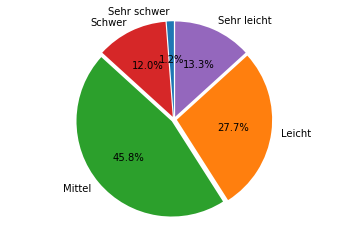

In [148]:
# Data to plot
cuts = [0, 0.45, 0.55, 0.7, 0.85, 1.0]
numbers_in_each_bracket = []
for i in range(len(cuts)):
    if (i <= 4):
        numbers_in_each_bracket.append(len(answersByDifficultyDf[(answersByDifficultyDf["Schwierigkeitsindex der Antwortoption"]>cuts[i]) & (answersByDifficultyDf["Schwierigkeitsindex der Antwortoption"]<cuts[i+1])]))
labels = ['Sehr schwer', 'Schwer', 'Mittel', 'Leicht', "Sehr leicht"]

sizes = numbers_in_each_bracket
explode = (0.03, 0.03, 0.03, 0.03, 0.03)

# Plot
fig, ax1 = plt.subplots(nrows=1, ncols=1)
colors = ["tab:blue", 'tab:red', 'tab:green', 'tab:orange', 'tab:purple']
#colors=["red", "mediumvioletred","purple", "blueviolet",  "blue"]
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, explode=explode, colors=colors)
plt.savefig('plots/schwierigkeit_pie.png', bbox_inches='tight')

plt.axis('equal')
plt.show()

#to print the values
#print(numbers_in_each_bracket)

# 4. Evaluation Lernfortschritt

## 4.1 KI
### KI - Selbsteinschätzung
Selbsteinschätzung der SuS zu zwei verschiedenen Zeitpunkten:
* T0: AI-1-v2-1-1
* T1-1 'AI-4-v2-1-4', 'Wie gut hast du jetzt verstanden, was KI ist?'

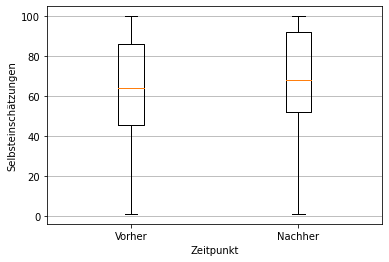


-----Test auf Normalverteilung-----
ShapiroResult(statistic=0.9526786208152771, pvalue=0.0006073114927858114)

-----Wilcoxon-----
WilcoxonResult(statistic=1755.0, pvalue=0.005437282165958155)

-----Effektstärken-----
-0.23904624233021857


In [201]:
# Ergebnisse Plotten
fig, ax1 = plt.subplots(nrows=1, ncols=1)
labels = ["Vorher", "Nachher"]
bplot1 = ax1.boxplot([pupil_performance_df.dropna(subset=["AI-1-v2-1-1", 'AI-4-v2-1-4'])["AI-1-v2-1-1"], pupil_performance_df.dropna(subset=["AI-1-v2-1-1", 'AI-4-v2-1-4'])["AI-4-v2-1-4"]],
                     vert=True,
                     labels=labels)
ax1.yaxis.grid(True)
ax1.set_xlabel("Zeitpunkt")
ax1.set_ylabel("Selbsteinschätzungen")
plt.savefig('plots/KI_selbsteinschätzung.png', bbox_inches='tight')
plt.show()


# Paarweise differenzen berechnen
differences_0_05 = calculateDifferences(pupil_performance_df[["AI-4-v2-1-4", "AI-1-v2-1-1"]])

# Test auf Normalverteilung
print("\n-----Test auf Normalverteilung-----")
print(stats.shapiro(differences_0_05))

# p-Wert = 0.0006 --> wilcoxon signed rank test
print("\n-----Wilcoxon-----")
print(stats.wilcoxon(differences_0_05))

print("\n-----Effektstärken-----")
print(cohen_d(pupil_performance_df.dropna(subset=["AI-1-v2-1-1", 'AI-4-v2-1-4'])["AI-1-v2-1-1"], pupil_performance_df.dropna(subset=["AI-1-v2-1-1", 'AI-4-v2-1-4'])["AI-4-v2-1-4"]))


#### KI - Selbsteinschätzungen - Korrelation mit meiner Bewertung der Textantworten

------------------ Vorher ---------------


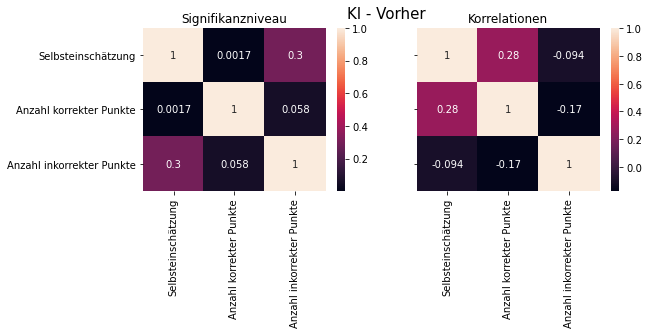

------------------ Nachher ---------------


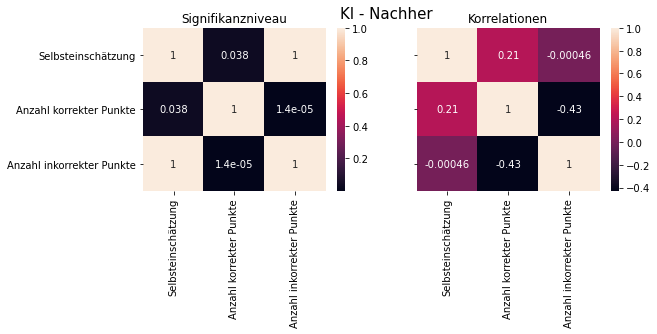

In [196]:
tasks = [("AI-1-v2-1-1", "AI-1-v2-1-2"), ('AI-4-v2-1-4', "AI-4-v2-1-3")]
timepointLabels = ["Vorher", "Nachher"]
timepoint = 0
for tpl in tasks:
    print("------------------", timepointLabels[timepoint], "---------------")
    p_values = pupil_performance_df_rated[[tpl[0], tpl[1]+ "_correct_points", tpl[1]+ "_incorrect_points"]].corr(method=spearmanr_pval)
    
    fig, axes = plt.subplots(1, 2, figsize=(9,3), sharey=True)
    fig.suptitle("KI - " + timepointLabels[timepoint], fontsize=15)
    
    labels = ["Selbsteinschätzung", "Anzahl korrekter Punkte", "Anzahl inkorrekter Punkte"]
    sns.heatmap(p_values, ax= axes[0], annot= True, xticklabels = labels, yticklabels = labels)
    axes[0].set_title("Signifikanzniveau")    

    sns.heatmap(pupil_performance_df_rated[[tpl[0], tpl[1]+ "_correct_points", tpl[1]+ "_incorrect_points"]].corr(method='spearman'), ax= axes[1], annot= True, xticklabels = labels, yticklabels = labels)
    axes[1].set_title("Korrelationen")
    plt.savefig("plots/KI_" + timepointLabels[timepoint] + "_complete.png", bbox_inches='tight')
    plt.show()
    timepoint +=1

### KI - Textantworten

#### KI - Textantworten - Länge der Abgaben

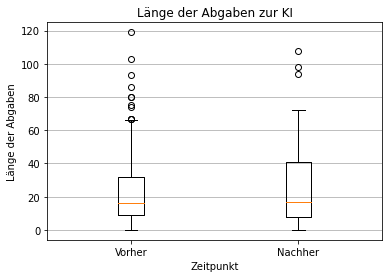

In [54]:
fig, ax1 = plt.subplots(nrows=1, ncols=1) #figsize=(9, 4)
labels = ["Vorher", "Nachher"]
bplot1 = ax1.boxplot([freetext[freetext["taskId"] == "AI-1-v2-1-2"]["number words in answer"], freetext[freetext["taskId"] == "AI-4-v2-1-3"]["number words in answer"]],
                     vert=True,
                     #patch_artist=True,
                     labels=labels)
ax1.yaxis.grid(True)
ax1.set_title('Länge der Abgaben zur KI')
ax1.set_xlabel("Zeitpunkt")
ax1.set_ylabel("Länge der Abgaben")
plt.savefig('plots/KI_textantworten_Längenvergleich.png', bbox_inches='tight')
plt.show()


#### KI - Textantworten  - unknown

Unknown ist True, wenn:
* die SuS explizit sagen, dass sie es nicht wissen


In [9]:
print("-----Anzahl Abgaben-----")
print("T0: ", len(pupil_performance_df_rated['AI-1-v2-1-2_null_answer'].dropna()))
print("T1: ", len(pupil_performance_df_rated['AI-4-v2-1-3_null_answer'].dropna()))
print("-----'Anzahl Ich weiß es nicht-Abgaben'-----")
print("T0: ", len(pupil_performance_df_rated[pupil_performance_df_rated['AI-1-v2-1-2_unknown']==True]))
print("T1: ", len(pupil_performance_df_rated[pupil_performance_df_rated['AI-4-v2-1-3_unknown']==True]))
print("-----Anzahl Leerabgaben und Plagiate-----")
print("T0: ", len(pupil_performance_df_rated[pupil_performance_df_rated['AI-1-v2-1-2_null_answer']==True]))
print("T1: ", len(pupil_performance_df_rated[pupil_performance_df_rated['AI-4-v2-1-3_null_answer']==True]))

proportionT0unknown = pupil_performance_df_rated[["AI-1-v2-1-2_unknown"]].value_counts()[True].values[0] / (pupil_performance_df_rated[["AI-1-v2-1-2_unknown"]].value_counts()[False].values[0] + pupil_performance_df_rated[["AI-1-v2-1-2_unknown"]].value_counts()[True].values[0])
proportionT1unknown = pupil_performance_df_rated[["AI-4-v2-1-3_unknown"]].value_counts()[True].values[0] / (pupil_performance_df_rated[["AI-4-v2-1-3_unknown"]].value_counts()[False].values[0] + pupil_performance_df_rated[["AI-4-v2-1-3_unknown"]].value_counts()[True].values[0])
proportionT0null = pupil_performance_df_rated[["AI-1-v2-1-2_null_answer"]].value_counts()[True].values[0] / (pupil_performance_df_rated[["AI-1-v2-1-2_null_answer"]].value_counts()[False].values[0] + pupil_performance_df_rated[["AI-1-v2-1-2_null_answer"]].value_counts()[True].values[0])
proportionT1null = pupil_performance_df_rated[["AI-4-v2-1-3_null_answer"]].value_counts()[True].values[0] / (pupil_performance_df_rated[["AI-4-v2-1-3_null_answer"]].value_counts()[False].values[0] + pupil_performance_df_rated[["AI-4-v2-1-3_null_answer"]].value_counts()[True].values[0])

print("\n-----Veränderung der Anteile-----")
print("Proportion Unknown: ", round(proportionT0unknown*100, 2), "-->", round(proportionT1unknown*100,2))

-----Anzahl Abgaben-----
T0:  141
T1:  111
-----'Anzahl Ich weiß es nicht-Abgaben'-----
T0:  2
T1:  3
-----Anzahl Leerabgaben und Plagiate-----
T0:  14
T1:  13

-----Veränderung der Anteile-----
Proportion Unknown:  1.42 --> 2.7


#### KI - Textantworten - Deskriptiv
##### Korrekte und Inkorrekte Punkte vorher und nachher

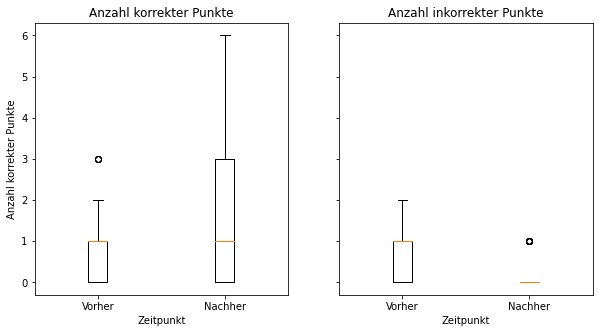

In [202]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5), sharey = True)
labels = ["Vorher", "Nachher"]
bplot1 = ax[0].boxplot([pupil_performance_df_rated.dropna(subset=["AI-4-v2-1-3_correct_points", "AI-1-v2-1-2_correct_points"])["AI-1-v2-1-2_correct_points"], pupil_performance_df_rated.dropna(subset=["AI-4-v2-1-3_correct_points", "AI-1-v2-1-2_correct_points"])["AI-4-v2-1-3_correct_points"]],
                     vert=True,
                     labels=labels)
bplot2 = ax[1].boxplot([pupil_performance_df_rated.dropna(subset=["AI-4-v2-1-3_incorrect_points", "AI-1-v2-1-2_incorrect_points"])["AI-1-v2-1-2_incorrect_points"], pupil_performance_df_rated.dropna(subset=["AI-4-v2-1-3_incorrect_points", "AI-1-v2-1-2_incorrect_points"])["AI-4-v2-1-3_incorrect_points"]],
                     vert=True,
                     labels=labels)

ax[0].set_xlabel("Zeitpunkt")
ax[1].set_xlabel("Zeitpunkt")
ax[0].set_ylabel("Anzahl korrekter Punkte")
ax[0].set_title('Anzahl korrekter Punkte')
ax[1].set_title('Anzahl inkorrekter Punkte')
plt.savefig('plots/KI_freetext_comparison_shared.png', bbox_inches='tight')
plt.show()

#### KI - Textantworten - Lerneffekt

In [27]:
KIdifferences_correct = calculateDifferences(pupil_performance_df_rated[["AI-4-v2-1-3_correct_points", "AI-1-v2-1-2_correct_points"]])
KIdifferences_incorrect = calculateDifferences(pupil_performance_df_rated[["AI-4-v2-1-3_incorrect_points", "AI-1-v2-1-2_incorrect_points"]])

print("-----Shapiro-----")
print(stats.shapiro(KIdifferences_correct))
print(stats.shapiro(KIdifferences_incorrect))

print("\n-----Signifikanz-----")
print(stats.wilcoxon(KIdifferences_correct))
print(stats.wilcoxon(KIdifferences_incorrect))

print("\n-----Effektstärke-----")
print(cohen_d(pupil_performance_df_rated.dropna(subset=["AI-4-v2-1-3_correct_points", "AI-1-v2-1-2_correct_points"])["AI-1-v2-1-2_correct_points"], pupil_performance_df_rated.dropna(subset=["AI-4-v2-1-3_correct_points", "AI-1-v2-1-2_correct_points"])["AI-4-v2-1-3_correct_points"]))
print(cohen_d(pupil_performance_df_rated.dropna(subset=["AI-4-v2-1-3_incorrect_points", "AI-1-v2-1-2_incorrect_points"])["AI-1-v2-1-2_incorrect_points"], pupil_performance_df_rated.dropna(subset=["AI-4-v2-1-3_incorrect_points", "AI-1-v2-1-2_incorrect_points"])["AI-4-v2-1-3_incorrect_points"]))


-----Shapiro-----
ShapiroResult(statistic=0.8644287586212158, pvalue=8.662321704377973e-08)
ShapiroResult(statistic=0.8164995312690735, pvalue=2.8508673199922896e-09)

-----Signifikanz-----
WilcoxonResult(statistic=122.5, pvalue=5.919715417692041e-10)
WilcoxonResult(statistic=123.0, pvalue=1.5945871800686743e-06)

-----Effektstärke-----
-0.8803577784139401
0.773017651715653


##### Lernfortschritt nach Klasse

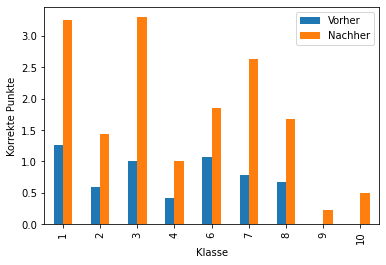

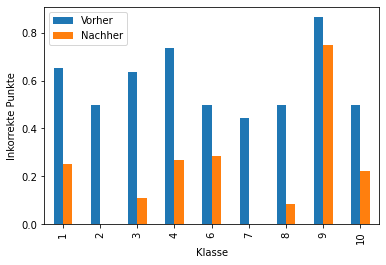

In [192]:
labels = ["Vorher", "Nachher"]
pupil_performance_df_rated.groupby("classId")[["AI-1-v2-1-2_correct_points", "AI-4-v2-1-3_correct_points"]].agg(np.mean).dropna().plot(y=["AI-1-v2-1-2_correct_points", "AI-4-v2-1-3_correct_points"], kind="bar")
#plt.title("Korrekte Punkte zur KI nach Klasse")
plt.xlabel('Klasse')
plt.ylabel('Korrekte Punkte')
plt.legend(labels)
plt.savefig('plots/KI_textanwort_korrekte_byclass.png', bbox_inches='tight')
plt.show()

pupil_performance_df_rated.groupby("classId")[["AI-1-v2-1-2_incorrect_points", "AI-4-v2-1-3_incorrect_points"]].agg(np.mean).dropna().plot(y=["AI-1-v2-1-2_incorrect_points", "AI-4-v2-1-3_incorrect_points"], kind="bar")
plt.xlabel('Klasse')
plt.ylabel('Inkorrekte Punkte')
plt.legend(labels)
plt.savefig('plots/KI_textanwort_inkorrekte_byclass.png', bbox_inches='tight')
plt.show()


## 4.2 ML
### ML - Selbsteinschätzung
* T0: 'ML-2-1-1' 'Wie gut weißt du schon, was Maschinelles Lernen ist?'
* T1: 'EvalML-1-5' Wie gut hast du verstanden, was maschinelles Lernen ist?

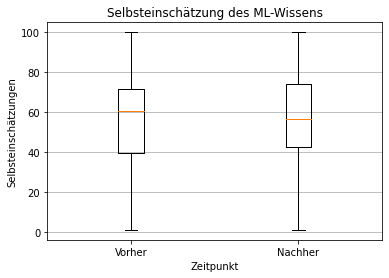

ShapirotestResult ShapiroResult(statistic=0.9749335646629333, pvalue=0.29257649183273315) 

Ttest_relResult(statistic=-0.10173317312577801, pvalue=0.9193384577871859)


In [190]:
fig, ax1 = plt.subplots(nrows=1, ncols=1)
labels = ["Vorher", "Nachher"]
bplot1 = ax1.boxplot([pupil_performance_df.dropna(subset=["ML-2-1-1", 'EvalML-1-5'])["ML-2-1-1"], pupil_performance_df.dropna(subset=["ML-2-1-1", 'EvalML-1-5'])["EvalML-1-5"]],
                     vert=True,
                     labels=labels)
ax1.yaxis.grid(True)
ax1.set_title('Selbsteinschätzung des ML-Wissens')
ax1.set_xlabel("Zeitpunkt")
ax1.set_ylabel("Selbsteinschätzungen")
plt.savefig('plots/ML_selbsteinschätzung.png', bbox_inches='tight')
plt.show()

differences_0_1 = calculateDifferences(pupil_performance_df[["EvalML-1-5", "ML-2-1-1"]])

print("ShapirotestResult", stats.shapiro(differences_0_1), "\n")

print(stats.ttest_rel(pupil_performance_df.dropna(subset=["EvalML-1-5", "ML-2-1-1"])["ML-2-1-1"], pupil_performance_df.dropna(subset=["EvalML-1-5", "ML-2-1-1"])["EvalML-1-5"]))

#### ML - Selbsteinschätzung - Korrelation mit meiner Bewertung der Textantworten

------------------ Vorher ---------------


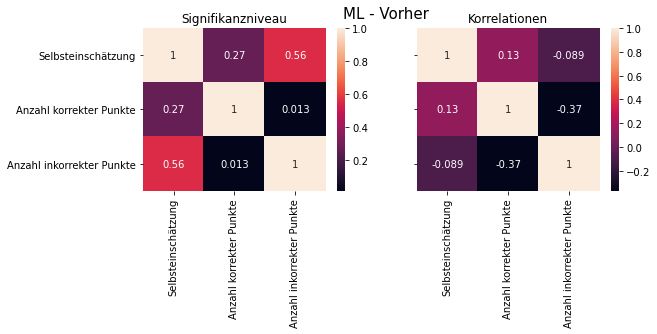

------------------ Nachher ---------------


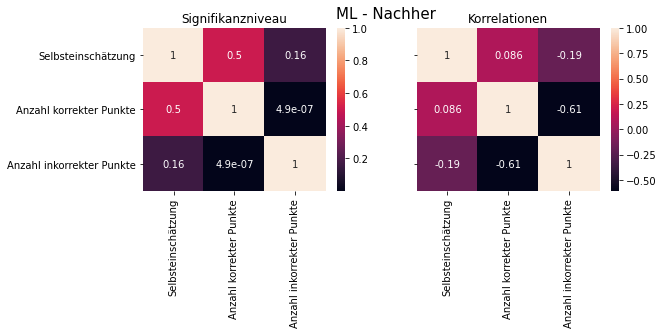

In [199]:
tasks = [("ML-2-1-1", "ML-2-1-2"), ('EvalML-1-5', "EvalML-1-7")]
timepointLabels = ["Vorher", "Nachher"]
timepoint = 0
for tpl in tasks:
    print("------------------", timepointLabels[timepoint], "---------------")
    p_values = pupil_performance_df_rated[[tpl[0], tpl[1]+ "_correct_points", tpl[1]+ "_incorrect_points"]].corr(method=spearmanr_pval)
    
    fig, axes = plt.subplots(1, 2, figsize=(9,3), sharey=True)
    fig.suptitle("ML - " + timepointLabels[timepoint], fontsize=15)
    
    labels = ["Selbsteinschätzung", "Anzahl korrekter Punkte", "Anzahl inkorrekter Punkte"]
    sns.heatmap(p_values, ax= axes[0], annot= True, xticklabels = labels, yticklabels = labels)
    axes[0].set_title("Signifikanzniveau")    

    sns.heatmap(pupil_performance_df_rated[[tpl[0], tpl[1]+ "_correct_points", tpl[1]+ "_incorrect_points"]].corr(method='spearman'), ax= axes[1], annot= True, xticklabels = labels, yticklabels = labels)
    axes[1].set_title("Korrelationen")
    plt.savefig("plots/ML_" + timepointLabels[timepoint] + "_complete.png", bbox_inches='tight')
    plt.show()
    timepoint +=1

### ML - Textantworten
* 'ML-2-1-1' - Weißt du vielleicht schon etwas über das maschinelle Lernen?
* 'EvalML-1-7' - Was ist ML in eigenen Worten

#### ML - Textantworten - Länge der Abgaben

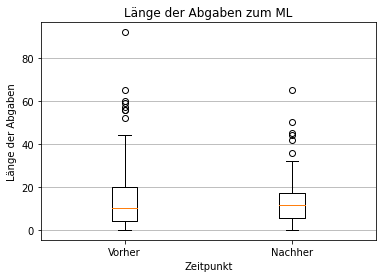

In [56]:
fig, ax1 = plt.subplots(nrows=1, ncols=1)
labels = ["Vorher", "Nachher"]
bplot1 = ax1.boxplot([freetext[freetext["taskId"] == "ML-2-1-2"]["number words in answer"], freetext[(freetext["taskId"] == "EvalML-1-7") & (freetext["number words in answer"] < 300 )]["number words in answer"]],
                     vert=True,
                     labels=labels)
ax1.yaxis.grid(True)
ax1.set_title('Länge der Abgaben zum ML')
ax1.set_xlabel("Zeitpunkt")
ax1.set_ylabel("Länge der Abgaben")
plt.savefig('plots/ML_textantworten_Längenvergleich.png', bbox_inches='tight')
plt.show()


#### ML - Textantworten - unknown

In [8]:
print("-----Anzahl Abgaben-----")
print("T0: ", len(pupil_performance_df_rated['ML-2-1-2_null_answer'].dropna()))
print("T1: ", len(pupil_performance_df_rated['EvalML-1-7_null_answer'].dropna()))
print("-----'Anzahl Ich weiß es nicht-Abgaben'-----")
print("T0: ", len(pupil_performance_df_rated[pupil_performance_df_rated['ML-2-1-2_unknown']==True]))
print("T1: ", len(pupil_performance_df_rated[pupil_performance_df_rated['EvalML-1-7_unknown']==True]))
print("-----Anzahl Leerabgaben und Plagiate-----")
print("T0: ", len(pupil_performance_df_rated[pupil_performance_df_rated['ML-2-1-2_null_answer']==True]))
print("T1: ", len(pupil_performance_df_rated[pupil_performance_df_rated['EvalML-1-7_null_answer']==True]))

proportionT0unknown = round((pupil_performance_df_rated[["ML-2-1-2_unknown"]].value_counts()[True].values[0] / (pupil_performance_df_rated[["ML-2-1-2_unknown"]].value_counts()[False].values[0] + pupil_performance_df_rated[["ML-2-1-2_unknown"]].value_counts()[True].values[0]))*100,2)
proportionT1unknown = round((pupil_performance_df_rated[["EvalML-1-7_unknown"]].value_counts()[True].values[0] / (pupil_performance_df_rated[["EvalML-1-7_unknown"]].value_counts()[False].values[0] + pupil_performance_df_rated[["EvalML-1-7_unknown"]].value_counts()[True].values[0]))*100,2)
proportionT0null = round((pupil_performance_df_rated[["ML-2-1-2_null_answer"]].value_counts()[True].values[0] / (pupil_performance_df_rated[["ML-2-1-2_null_answer"]].value_counts()[False].values[0] + pupil_performance_df_rated[["ML-2-1-2_null_answer"]].value_counts()[True].values[0]))*100,2)
proportionT1null = round((pupil_performance_df_rated[["EvalML-1-7_null_answer"]].value_counts()[True].values[0] / (pupil_performance_df_rated[["EvalML-1-7_null_answer"]].value_counts()[False].values[0] + pupil_performance_df_rated[["EvalML-1-7_null_answer"]].value_counts()[True].values[0]))*100,2)

print("\n-----Prozentuale Veränderung-----")
print("Proportion Unknown: ", proportionT0unknown, "-->", proportionT1unknown)

-----Anzahl Abgaben-----
T0:  84
T1:  72
-----'Anzahl Ich weiß es nicht-Abgaben'-----
T0:  29
T1:  7
-----Anzahl Leerabgaben und Plagiate-----
T0:  11
T1:  9

-----Prozentuale Veränderung-----
Proportion Unknown:  34.52 --> 9.72


#### ML - Textantworten - Deskriptiv
##### Korrekte und Inkorrekte zu beiden Zeitpunkten

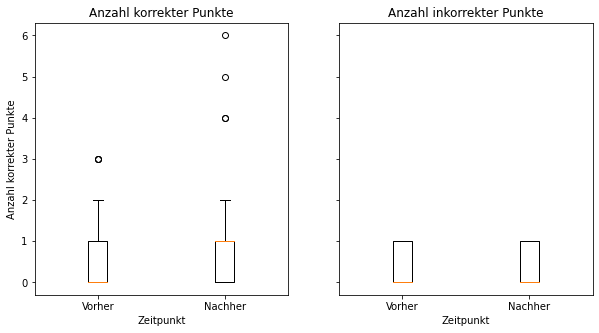

In [200]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5), sharey = True)
labels = ["Vorher", "Nachher"]
bplot1 = ax[0].boxplot([pupil_performance_df_rated.dropna(subset=["ML-2-1-2_correct_points", "EvalML-1-7_correct_points"])["ML-2-1-2_correct_points"], pupil_performance_df_rated.dropna(subset=["ML-2-1-2_correct_points", "EvalML-1-7_correct_points"])["EvalML-1-7_correct_points"]],
                     vert=True,
                     labels=labels)
bplot2 = ax[1].boxplot([pupil_performance_df_rated.dropna(subset=["ML-2-1-2_incorrect_points", "EvalML-1-7_incorrect_points"])["ML-2-1-2_incorrect_points"], pupil_performance_df_rated.dropna(subset=["ML-2-1-2_incorrect_points", "EvalML-1-7_incorrect_points"])["EvalML-1-7_incorrect_points"]],
                     vert=True,
                     labels=labels)

ax[0].set_xlabel("Zeitpunkt")
ax[1].set_xlabel("Zeitpunkt")
ax[0].set_ylabel("Anzahl korrekter Punkte")
ax[0].set_title('Anzahl korrekter Punkte')
ax[1].set_title('Anzahl inkorrekter Punkte')
plt.savefig('plots/ML_freetext_comparison_shared.png', bbox_inches='tight')
plt.show()

#### ML - Textantworten - Lerneffekt

In [6]:
MLdifferences_correct = calculateDifferences(pupil_performance_df_rated[["EvalML-1-7_correct_points", "ML-2-1-2_correct_points"]])
MLdifferences_incorrect = calculateDifferences(pupil_performance_df_rated[["EvalML-1-7_incorrect_points", "ML-2-1-2_incorrect_points"]])

print("\n-----Normalverteilung?-----")
print(stats.shapiro(MLdifferences_correct))
print(stats.shapiro(MLdifferences_incorrect))

print("\n-----Signifikanz-----")
print(stats.wilcoxon(MLdifferences_correct))
print(stats.wilcoxon(MLdifferences_incorrect))

print("\n-----Effektstärke-----")
print(cohen_d(pupil_performance_df_rated.dropna(subset=["EvalML-1-7_correct_points", "ML-2-1-2_correct_points"])["EvalML-1-7_correct_points"], pupil_performance_df_rated.dropna(subset=["EvalML-1-7_correct_points", "ML-2-1-2_correct_points"])["ML-2-1-2_correct_points"]))
print(cohen_d(pupil_performance_df_rated.dropna(subset=["EvalML-1-7_incorrect_points", "ML-2-1-2_incorrect_points"])["EvalML-1-7_incorrect_points"], pupil_performance_df_rated.dropna(subset=["EvalML-1-7_incorrect_points", "ML-2-1-2_incorrect_points"])["AI-4-v2-1-3_incorrect_points"]))



-----Normalverteilung?-----
ShapiroResult(statistic=0.863905131816864, pvalue=8.516922389389947e-05)
ShapiroResult(statistic=0.6908186674118042, pvalue=1.0665431545930915e-05)

-----Signifikanz-----
WilcoxonResult(statistic=61.5, pvalue=0.016453801586694634)
WilcoxonResult(statistic=7.0, pvalue=0.4142161782425253)

-----Effektstärke-----
0.39490425053246486
0.9095394684417764


/Users/jean-philipp/Documents/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/jean-philipp/Documents/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


##### ML - Textantworten - Unterschiede zwischen Klassen

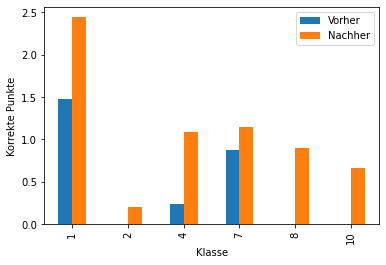

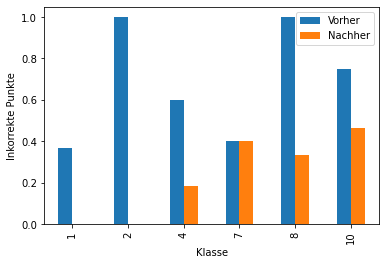

In [191]:
labels = ["Vorher", "Nachher"]
pupil_performance_df_rated.groupby("classId")[["ML-2-1-2_correct_points", "EvalML-1-7_correct_points"]].agg(np.mean).dropna().plot(y=["ML-2-1-2_correct_points", "EvalML-1-7_correct_points"], kind="bar")
#plt.title("Korrekte Punkte zum ML nach Klasse")
plt.xlabel('Klasse')
plt.ylabel('Korrekte Punkte')
plt.legend(labels)
plt.savefig('plots/ML_textanwort_korrekte_byclass.png', bbox_inches='tight')
plt.show()

pupil_performance_df_rated.groupby("classId")[["ML-2-1-2_incorrect_points", "EvalML-1-7_incorrect_points"]].agg(np.mean).dropna().plot(y=["ML-2-1-2_incorrect_points", "EvalML-1-7_incorrect_points"], kind="bar")
plt.xlabel('Klasse')
plt.ylabel('Inkorrekte Punkte')
plt.legend(labels)
plt.savefig('plots/ML_textanwort_inkorrekte_byclass.png', bbox_inches='tight')
plt.show()

### Trainingsdaten & Ablauf überwachtes Lernen - Textantworten

In [62]:
print(pupil_performance_df_rated.where(pupil_performance_df_rated["LimitsML-1-2_null_answer"] != True)["LimitsML-1-2_correct_points"].dropna().value_counts())

number_correct_cases = pupil_performance_df_rated.where(pupil_performance_df_rated["LimitsML-1-2_null_answer"] != True)["LimitsML-1-2_correct_points"].dropna().value_counts().values[0]
number_incorrect_cases = pupil_performance_df_rated.where(pupil_performance_df_rated["LimitsML-1-2_null_answer"] != True)["LimitsML-1-2_correct_points"].dropna().value_counts().values[1]
percentage_correct = number_correct_cases / (number_correct_cases + number_incorrect_cases)

print("\nAnteil richtiger Antworten: ", round(percentage_correct, 4))

1.0    40
0.0    29
Name: LimitsML-1-2_correct_points, dtype: int64

Anteil richtiger Antworten:  0.5797


#### Trainingsdaten & Ablauf überwachtes Lernen - Textantworten - Unterschiede zwischen den Klassen

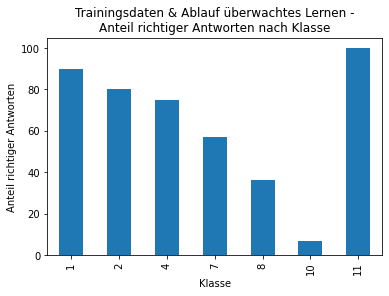

In [93]:
pd.DataFrame(pupil_performance_df_rated[pupil_performance_df_rated["LimitsML-1-2_null_answer"] != True].groupby("classId")["LimitsML-1-2_correct_points"].agg(np.mean).apply(lambda num : num*100).dropna()).plot(kind="bar", legend=False)
plt.title("Trainingsdaten & Ablauf überwachtes Lernen -\nAnteil richtiger Antworten nach Klasse")
plt.xlabel('Klasse')
plt.ylabel('Anteil richtiger Antworten')
plt.savefig('plots/GrenzenMLbyKlasse.png', bbox_inches='tight')
plt.show()
